In [652]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error


# Lab 1

## Goal of the Report

The goal is to find which univariate linear regression model can best predict the median house value in given cities in California.

We will train three models using three different features: median income, population and number of households, and compare their performance using MAE and MSE.

## Dataset

The dataset is [California Housing Prices](https://www.kaggle.com/datasets/camnugent/california-housing-prices) from Kaggle. It contains median house prices for California districts derived from the 1990 census.

## Exploratory Data Analysis

### Load and Explore the Dataset

In [653]:
# load the dataset
df = pd.read_csv('./data/housing.csv')

In [654]:
# explore statistics
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


### Median House Value vs. Median Income 

This scatter plot shows the relationship between median house value and median income.

Through the plot, we can see that there is a positive correlation between median house value and median income. As median income increases, median house value increases as well.

At the top of the plot, there are a lot of points that form a horizontal line, which indicates that they are outliers. We need to remove them before training the model.

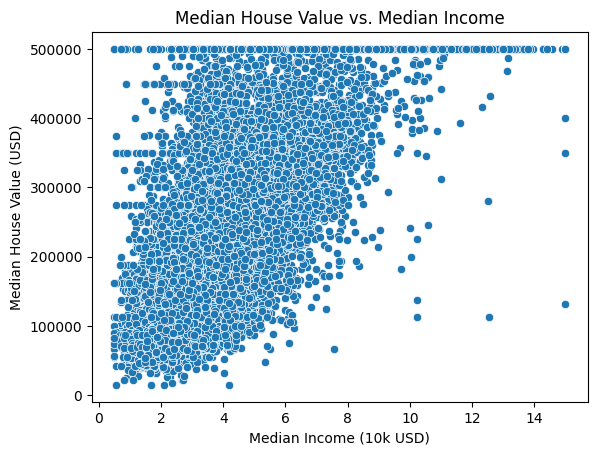

In [655]:
sns.scatterplot(df, x='median_income', y='median_house_value')
plt.title('Median House Value vs. Median Income')
plt.xlabel('Median Income (10k USD)')
plt.ylabel('Median House Value (USD)')
plt.show()

### Median House Value vs. Population

This scatter plot shows the relationship between median house value and population of a block.

Through the plot, we can see that there is no clear correlation between median house value and population. As population increases, median house value does not clearly increase or decrease.

At the top of the plot, there are a lot of points that form a horizontal line, which indicates that they are outliers. We need to remove them before training the model.

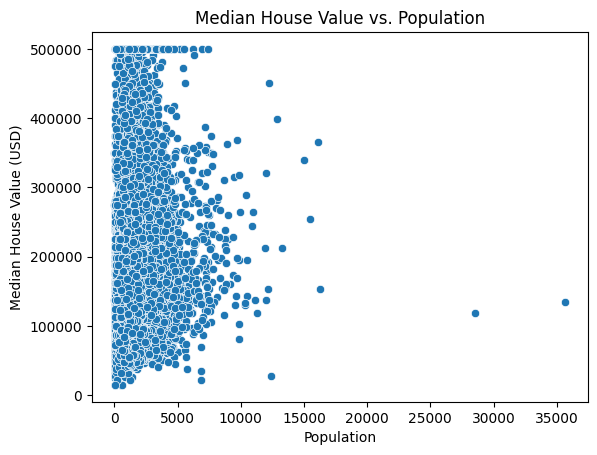

In [656]:
sns.scatterplot(df, x='population', y='median_house_value')
plt.title('Median House Value vs. Population')
plt.xlabel('Population')
plt.ylabel('Median House Value (USD)')
plt.show()

### Median House Value vs. Number of Households

This scatter plot shows the relationship between median house value and the number of households in a block.

Through the plot, we can see that there is no clear correlation between median house value and number of households. As the number of households increases, median house value does not clearly increase or decrease.

At the top of the plot, there are a lot of points that form a horizontal line, which indicates that they are outliers. We need to remove them before training the model.

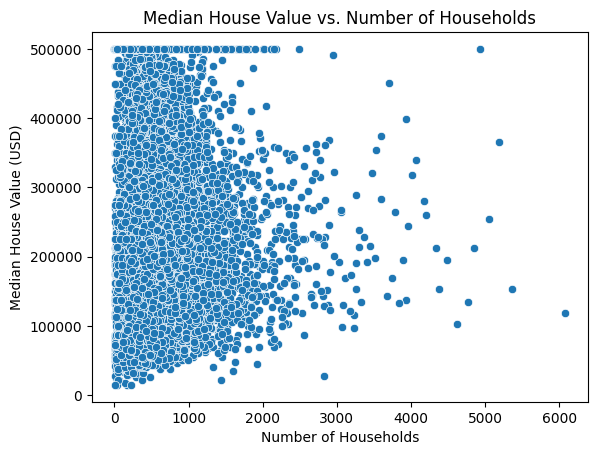

In [657]:
sns.scatterplot(df, x='households', y='median_house_value')
plt.title('Median House Value vs. Number of Households')
plt.xlabel('Number of Households')
plt.ylabel('Median House Value (USD)')
plt.show()

### Summary

#### Explanation of the features

* **median_house_value:**
  * median house value for households within a block (measured in US Dollars)
  * range from `$14,999` to `$500,001`
* **median_income:**
  * median income for households within a block of houses (measured in tens of thousands of US Dollars)
  * range from `$4,999` to `$150,001`
* **population:**
  * total number of people residing within a block
  * range from `3` to `35682`
* **households:**
  * total number of households, a group of people residing within a home unit, for a block
  * range from `1` to `6082`

#### Observations

* There is a positive correlation between median house value and median income, while the two other features do not show a clear correlation.
* There are outliers in all three scatter plots.
  * We need to remove the data which has a median house value of `$500,001` before training the models. 
  * Also, we need to remove the data which has a population of more than `25,000`.

## Data Processing

### Data Cleansing

In [658]:
# remove outliers
df_cleaned = df[df['median_house_value'] != 500001]
df_cleaned = df_cleaned[df_cleaned['population'] < 25000]

records_cleaned = len(df) - len(df_cleaned)
print(f'{records_cleaned} outliers removed.\nBefore: {len(df)} rows\nAfter: {len(df_cleaned)} rows')

967 outliers removed.
Before: 20640 rows
After: 19673 rows


#### Median house value vs. median income after data cleansing

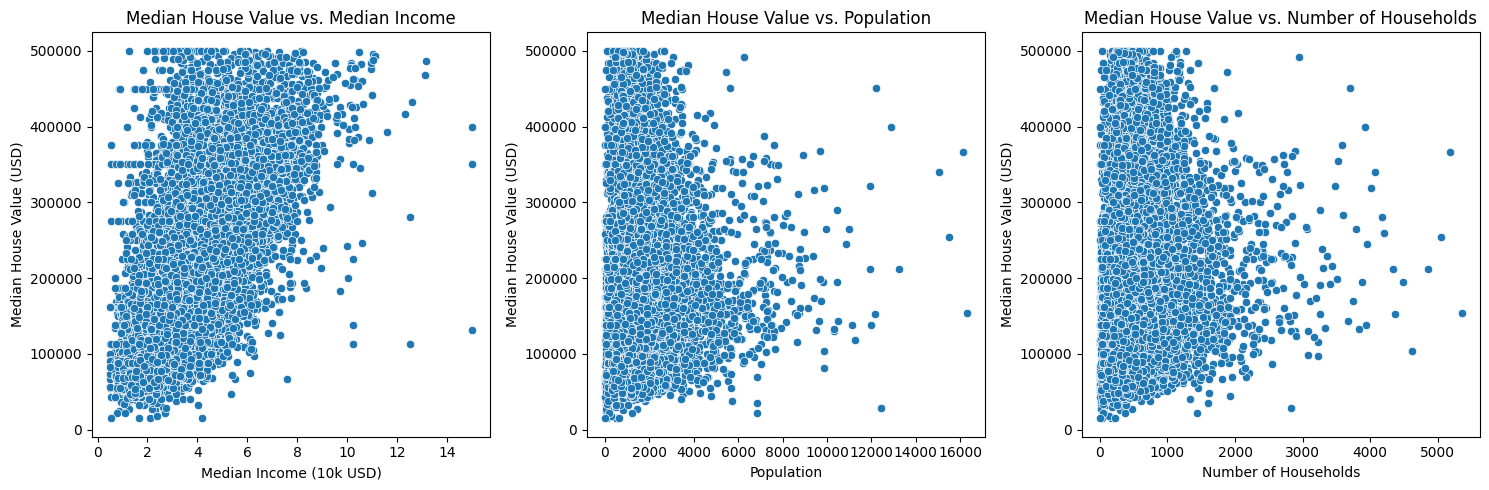

In [659]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.scatterplot(df_cleaned, x='median_income', y='median_house_value', ax=axes[0])
axes[0].set_title('Median House Value vs. Median Income')
axes[0].set_xlabel('Median Income (10k USD)')
axes[0].set_ylabel('Median House Value (USD)')

sns.scatterplot(df_cleaned, x='population', y='median_house_value', ax=axes[1])
axes[1].set_title('Median House Value vs. Population')
axes[1].set_xlabel('Population')
axes[1].set_ylabel('Median House Value (USD)')

sns.scatterplot(df_cleaned, x='households', y='median_house_value', ax=axes[2])
axes[2].set_title('Median House Value vs. Number of Households')
axes[2].set_xlabel('Number of Households')
axes[2].set_ylabel('Median House Value (USD)')

plt.tight_layout()
plt.show()

### Splitting Train Set and Test Set

Split the dataset into 80% training set and 20% test set.

In [660]:
# shuffle the dataset
shuffled_df = df_cleaned.sample(frac=1, random_state=114514)

# split the dataset
train_set_size = int(len(df_cleaned) * 0.8)
train_set = shuffled_df[:train_set_size]
test_set = shuffled_df[train_set_size:]

print(f'Train set size: {len(train_set)}\nTest set size: {len(test_set)}')

Train set size: 15738
Test set size: 3935


Plot the train set in blue and the test set in red.

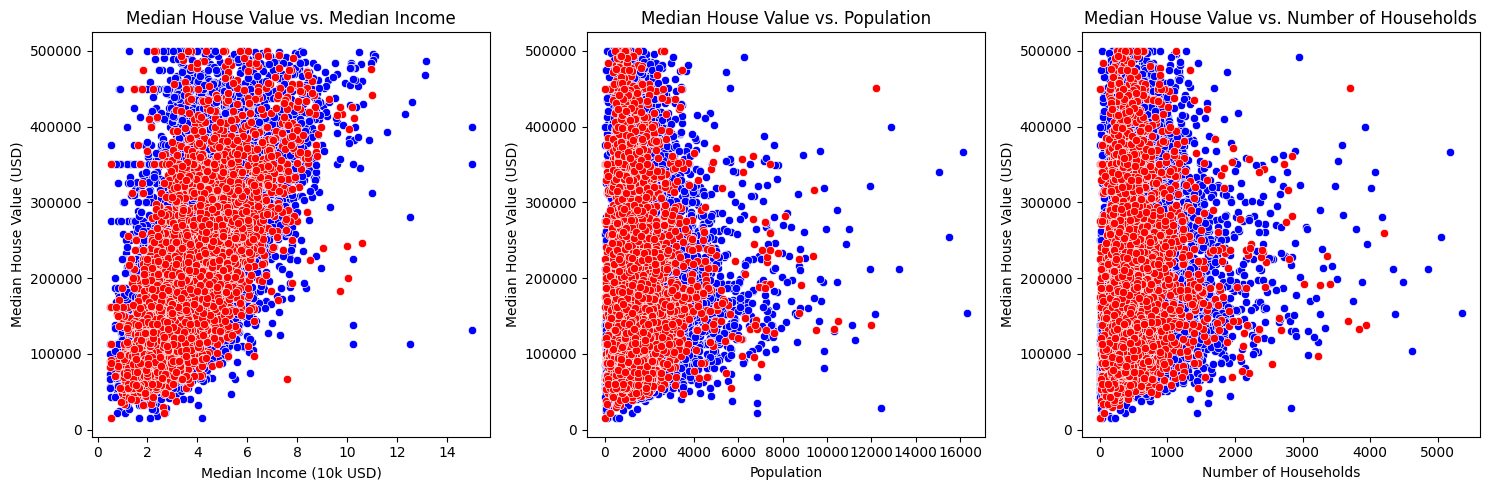

In [661]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.scatterplot(train_set, x='median_income', y='median_house_value', ax=axes[0], color='blue')
sns.scatterplot(test_set, x='median_income', y='median_house_value', ax=axes[0], color='red')
axes[0].set_title('Median House Value vs. Median Income')
axes[0].set_xlabel('Median Income (10k USD)')
axes[0].set_ylabel('Median House Value (USD)')

sns.scatterplot(train_set, x='population', y='median_house_value', ax=axes[1], color='blue')
sns.scatterplot(test_set, x='population', y='median_house_value', ax=axes[1], color='red')
axes[1].set_title('Median House Value vs. Population')
axes[1].set_xlabel('Population')
axes[1].set_ylabel('Median House Value (USD)')

sns.scatterplot(train_set, x='households', y='median_house_value', ax=axes[2], color='blue')
sns.scatterplot(test_set, x='households', y='median_house_value', ax=axes[2], color='red')
axes[2].set_title('Median House Value vs. Number of Households')
axes[2].set_xlabel('Number of Households')
axes[2].set_ylabel('Median House Value (USD)')

plt.tight_layout()
plt.show()

## Training and Testing

### Define Models

In [662]:
income_model = linear_model.LinearRegression()
population_model = linear_model.LinearRegression()
households_model = linear_model.LinearRegression()

### Train the models

In [663]:
income_model.fit(X=train_set[['median_income']], y=train_set['median_house_value'])
population_model.fit(X=train_set[['population']], y=train_set['median_house_value'])
households_model.fit(X=train_set[['households']], y=train_set['median_house_value'])

LinearRegression()

### Evaluate the models

#### Table of metrics

In [664]:
def calc_metrics(model, feature):
  intercept = model.intercept_
  slope = model.coef_[0]
  predictions = model.predict(test_set[[feature]])
  mae = mean_absolute_error(test_set['median_house_value'], predictions)
  mse = mean_squared_error(test_set['median_house_value'], predictions)
  return intercept, slope, mae, mse


# calc intercept, slope, MAE and MSE
income_model_metrics = calc_metrics(income_model, 'median_income')
population_model_metrics = calc_metrics(population_model, 'population')
households_model_metrics = calc_metrics(households_model, 'households')

metrics_table = pd.DataFrame(
    columns=['Regression Model', 'Intercept', 'Slope', 'Mean Absolute Error', 'Mean Squared Error'],
    data=[
      ['Median Income', *income_model_metrics],
      ['Population', *population_model_metrics],
      ['Number of Households', *households_model_metrics]
    ]
)

metrics_table

,Regression Model,Intercept,Slope,Mean Absolute Error,Mean Squared Error
0,Median Income,46855.585141,39611.107357,56471.862352,5.460773e+09
1,Population,190572.059969,1.216112,79099.382349,9.729210e+09
2,Number of Households,179784.966064,24.959449,78600.530063,9.645728e+09


#### Median House Value vs. Median Income Visualization

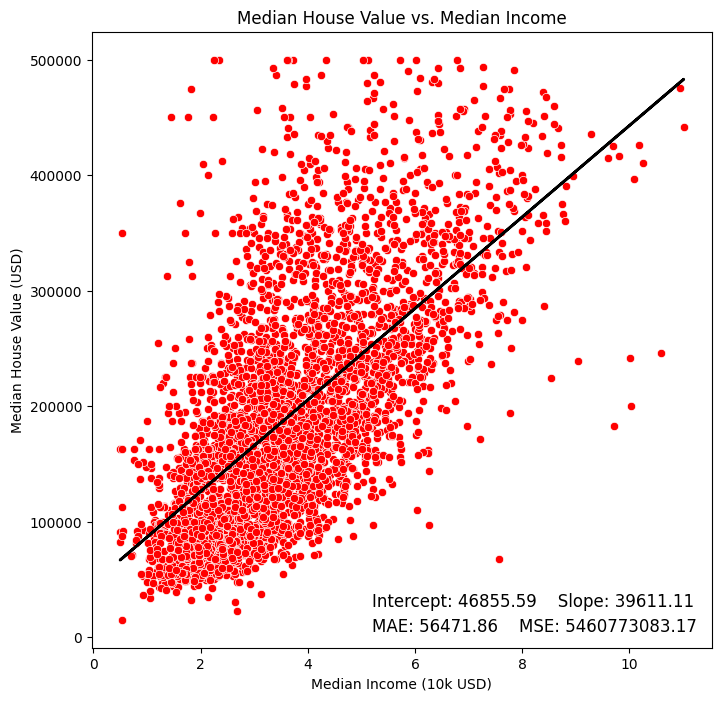

In [665]:
plt.figure(figsize=(8, 8))
sns.scatterplot(test_set, x='median_income', y='median_house_value', color='red')

# plot the regression line
predictions = income_model.predict(test_set[['median_income']])
plt.plot(test_set['median_income'], predictions, color='black', linewidth=2)

# plot the intercept, slope, MAE and MSE
intercept, slope, mae, mse = income_model_metrics
metrics_text = f'Intercept: {intercept:.2f}    Slope: {slope:.2f}\nMAE: {mae:.2f}    MSE: {mse:.2f}'
plt.text(5.2, 5000, metrics_text, fontsize=12, linespacing=1.5)

plt.title('Median House Value vs. Median Income')
plt.xlabel('Median Income (10k USD)')
plt.ylabel('Median House Value (USD)')
plt.show()

#### Median House Value vs. Population Visualization

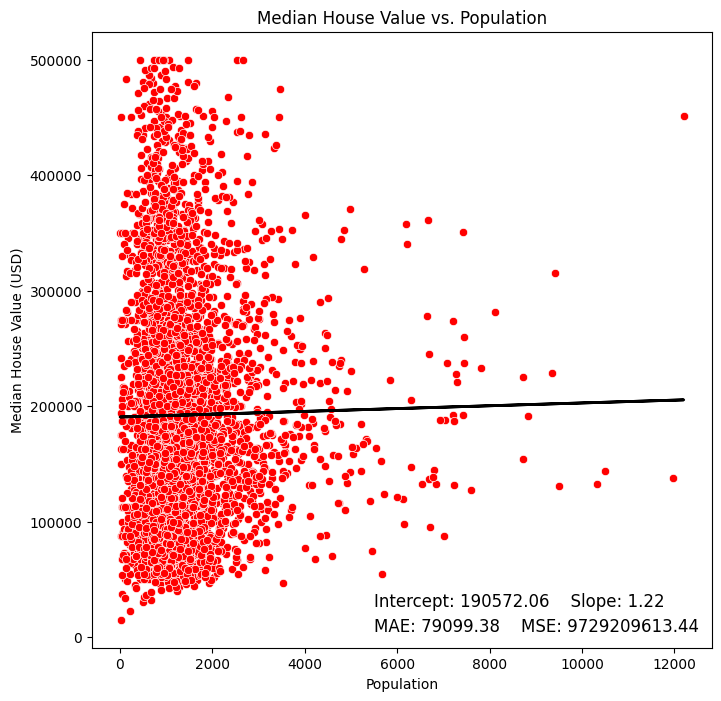

In [666]:
plt.figure(figsize=(8, 8))
sns.scatterplot(test_set, x='population', y='median_house_value', color='red')

# plot the regression line
predictions = population_model.predict(test_set[['population']])
plt.plot(test_set['population'], predictions, color='black', linewidth=2)

# plot the intercept, slope, MAE and MSE
intercept, slope, mae, mse = population_model_metrics
metrics_text = f'Intercept: {intercept:.2f}    Slope: {slope:.2f}\nMAE: {mae:.2f}    MSE: {mse:.2f}'
plt.text(5500, 5000, metrics_text, fontsize=12, linespacing=1.5)

plt.title('Median House Value vs. Population')
plt.xlabel('Population')
plt.ylabel('Median House Value (USD)')
plt.show()

#### Median House Value vs. Number of Households Visualization

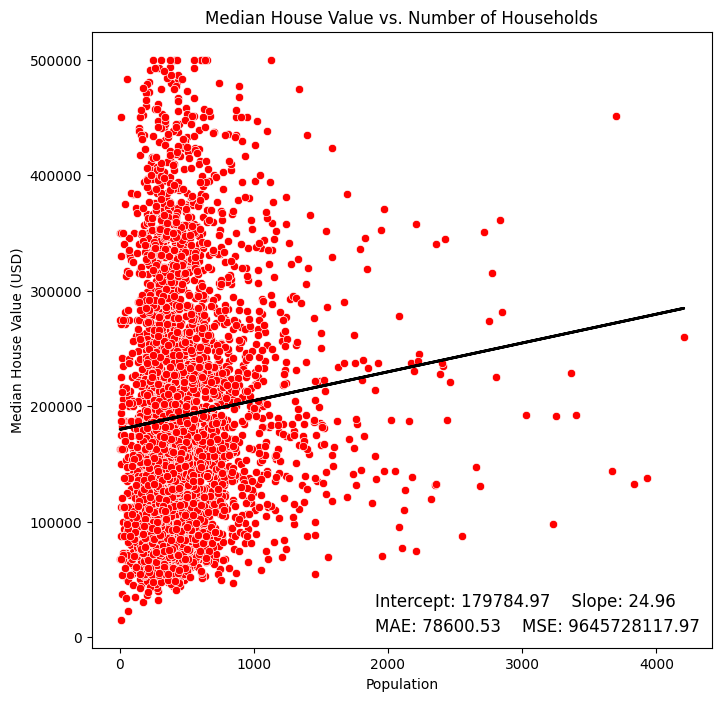

In [667]:
plt.figure(figsize=(8, 8))
sns.scatterplot(test_set, x='households', y='median_house_value', color='red')

# plot the regression line
predictions = households_model.predict(test_set[['households']])
plt.plot(test_set['households'], predictions, color='black', linewidth=2)

# plot the intercept, slope, MAE and MSE
intercept, slope, mae, mse = households_model_metrics
metrics_text = f'Intercept: {intercept:.2f}    Slope: {slope:.2f}\nMAE: {mae:.2f}    MSE: {mse:.2f}'
plt.text(1900, 5000, metrics_text, fontsize=12, linespacing=1.5)

plt.title('Median House Value vs. Number of Households')
plt.xlabel('Population')
plt.ylabel('Median House Value (USD)')
plt.show()

## Conclusion

* There is a clear positive linear relationship between median house value and median income. As median income increases, median house value increases as well.
* There is no significant linear relationship between median house value and population or number of households. The two features do not clearly affect median house value.
* The model using median income as a feature has the lowest MAE and MSE among all three models. It is the best model to predict median house value among the three models.